<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Analyzing the Altman Z-Score with Alphalens

Let's use Alphalens to explore the forward performance of stocks based on their Altman Z-Score. Instead of forming equal-sizes quantiles, let's suppose we want to form bins corresponding to the Altman Z-Scores three "zones":

* Distress Zone: Z-Score < 0
* Grey Zone: 0 < Z-Score < 3
* Safe zone: Z-Score > 3

Defining your own bin edges can be done either when using Alphalens' `from_pipeline()` function or in your Pipeline definition itself. First, we'll show how to do it in Alphalens, and then we'll show how to do it in Pipeline.

## Defining bin edges in Alphalens

To define the bin edges in Alphalens, we can start by creating a simple Pipeline that contains the Altman Z-Score factor: 

In [8]:
from zipline.pipeline import sharadar, Pipeline
from codeload.fundamental_factors.universe import BaseUniverse

universe = BaseUniverse() 

altman = sharadar.AltmanZScore('ART', mask=universe)

pipeline = Pipeline(
    columns={
        'altman': altman,
    },
    screen=universe & altman.notnull()
)

The Alphalens `from_pipeline()` function contains two, mutually exclusive parameters that control how the factor will be binned: `quantiles` and `bins`. 

In the previous notebooks, we specified `quantiles=n` to create `n` equal-sized bins. Under the hood, this caused Alphalens to pass the factor data to pandas' `qcut()` function, which calculates the bin edges needed to have the same number of items in each bin.   

In this notebook, we will use the `bins` argument to tell Alphalens where the bin edges should be. Under the hood, this will cause Alphalens to pass the factor data to pandas' `cut()` function. To split the data into three bins - below 0, to 3, and above 3 - we can pass the following `bins` argument:

```python
bins=[-float("inf"), 0, 3, float("inf")]
```

Since we want 3 bins, we have to pass 4 bin edges. The first bin will include everything from minus infinity to 0, including 0; the second bin will contain everything above 0 and below or equal to 3; and the third bin will contain everything above 3 and less than or equal to infinity.


,min,max,mean,std,count,avg daily count,count %
Factor Quantile,,,,,,,
1,"-326,034.031",-0.000,-13.480,"1,223.742","1,614,277",280.6,9.4%
2,0.000,3.000,1.736,0.778,"6,350,438",1103.8,37.1%
3,3.000,"98,844.000",13.612,306.720,"9,131,410",1587.2,53.4%


,1D,21D,5D
Ann. alpha,-0.032,-0.024,-0.020
beta,0.057,-0.020,0.022
Mean Relative Return Top Quantile (bps),0.418,0.054,0.246
Mean Relative Return Bottom Quantile (bps),-3.710,-2.309,-3.210
Mean Spread (bps),4.129,2.926,3.742


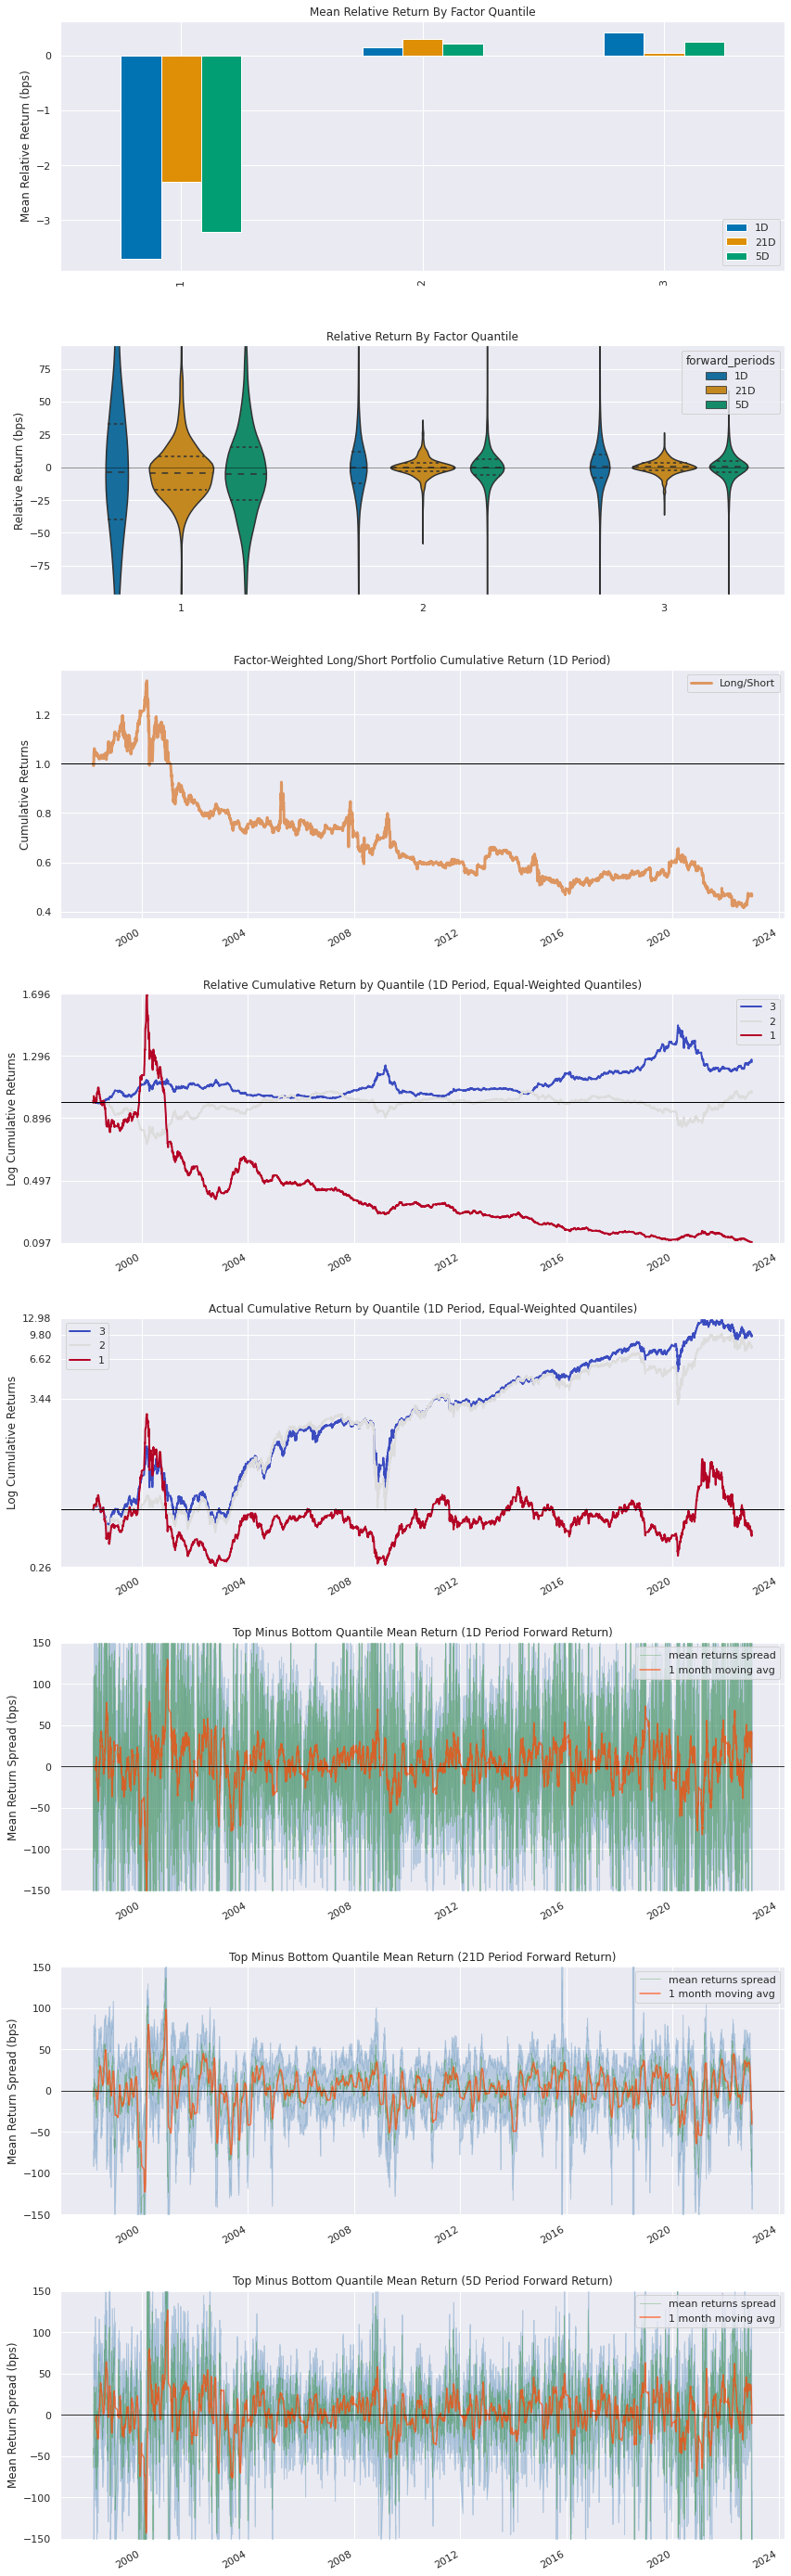

,1D,21D,5D
IC Mean,0.012,0.020,0.017
IC Std.,0.065,0.083,0.073
Risk-Adjusted IC,0.178,0.241,0.233
t-stat(IC),13.515,18.246,17.671
p-value(IC),0.000,0.000,0.000
IC Skew,-0.087,-0.254,-0.247
IC Kurtosis,0.959,0.201,0.907


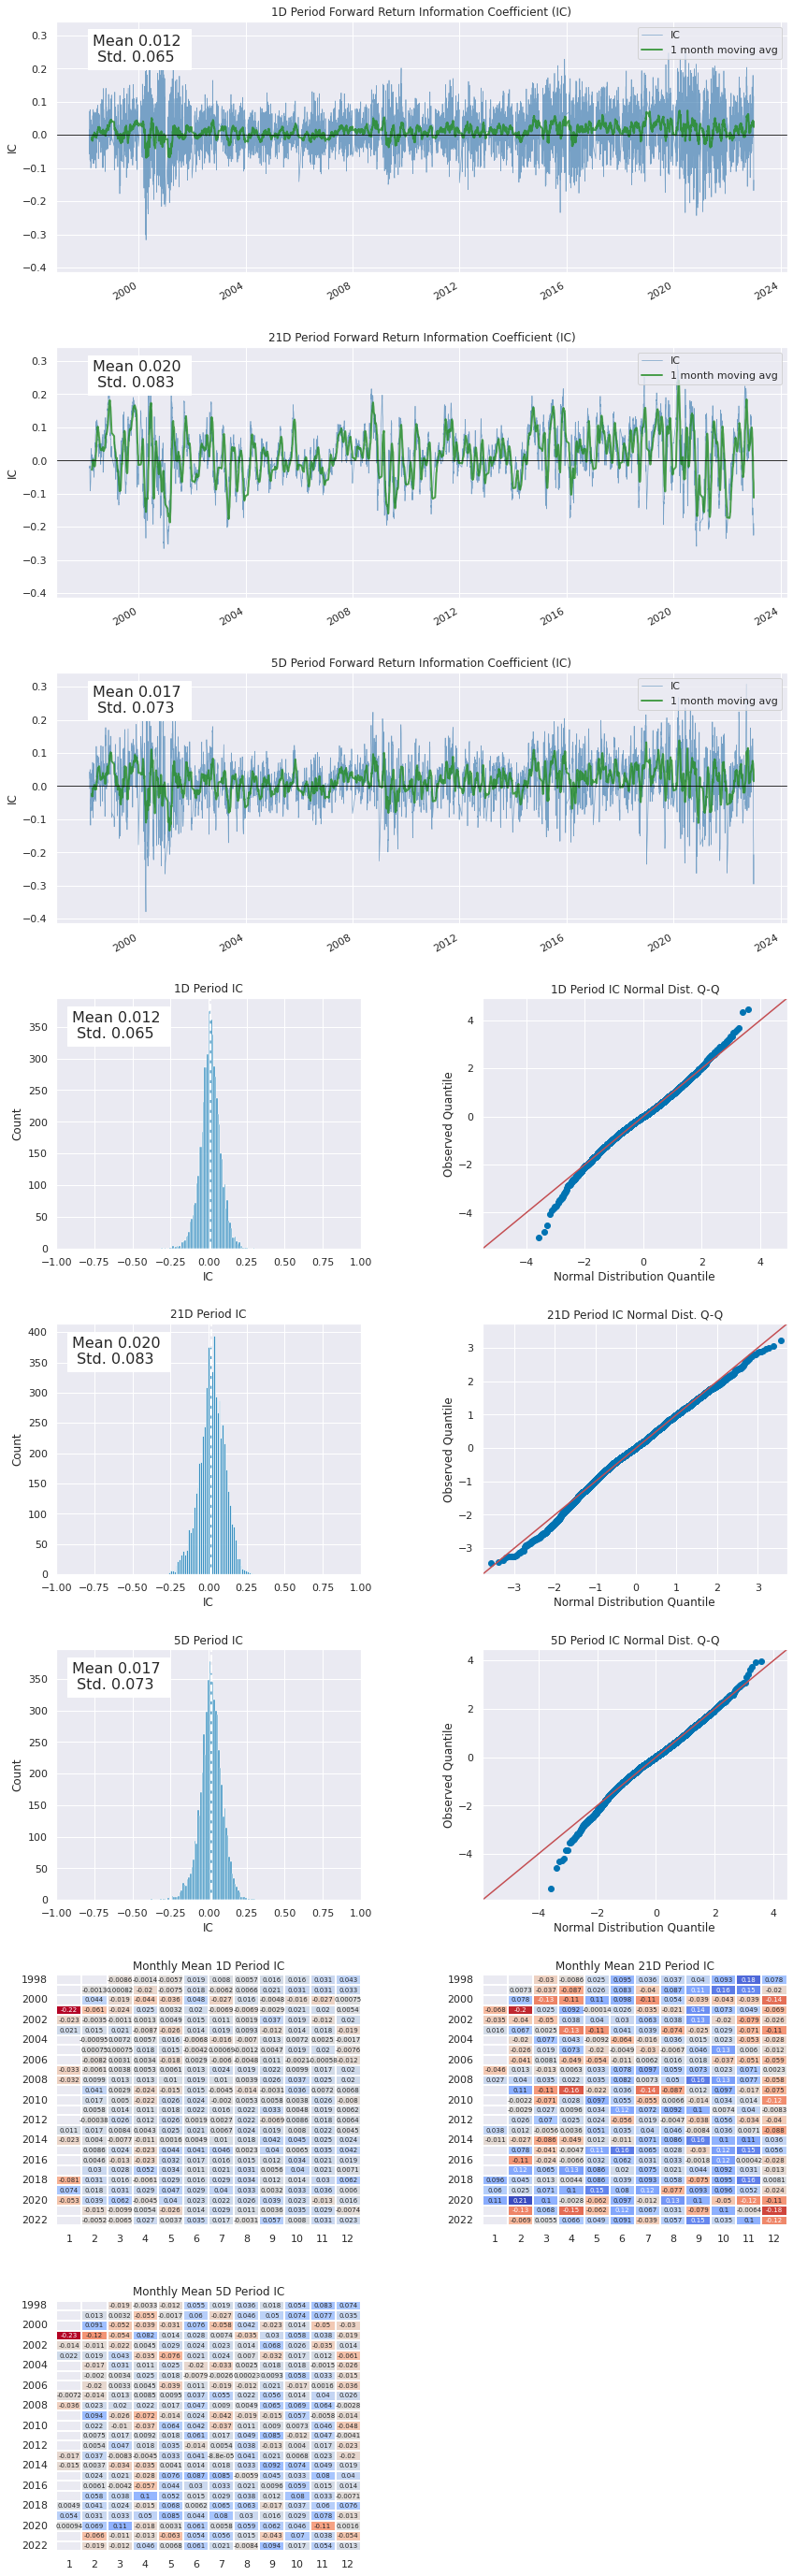

,1D,5D,21D
Quantile 1 Mean Turnover,0.008,0.039,0.140
Quantile 2 Mean Turnover,0.004,0.020,0.073
Quantile 3 Mean Turnover,0.003,0.014,0.051


,1D,21D,5D
Mean Factor Rank Autocorrelation,0.999,0.976,0.994


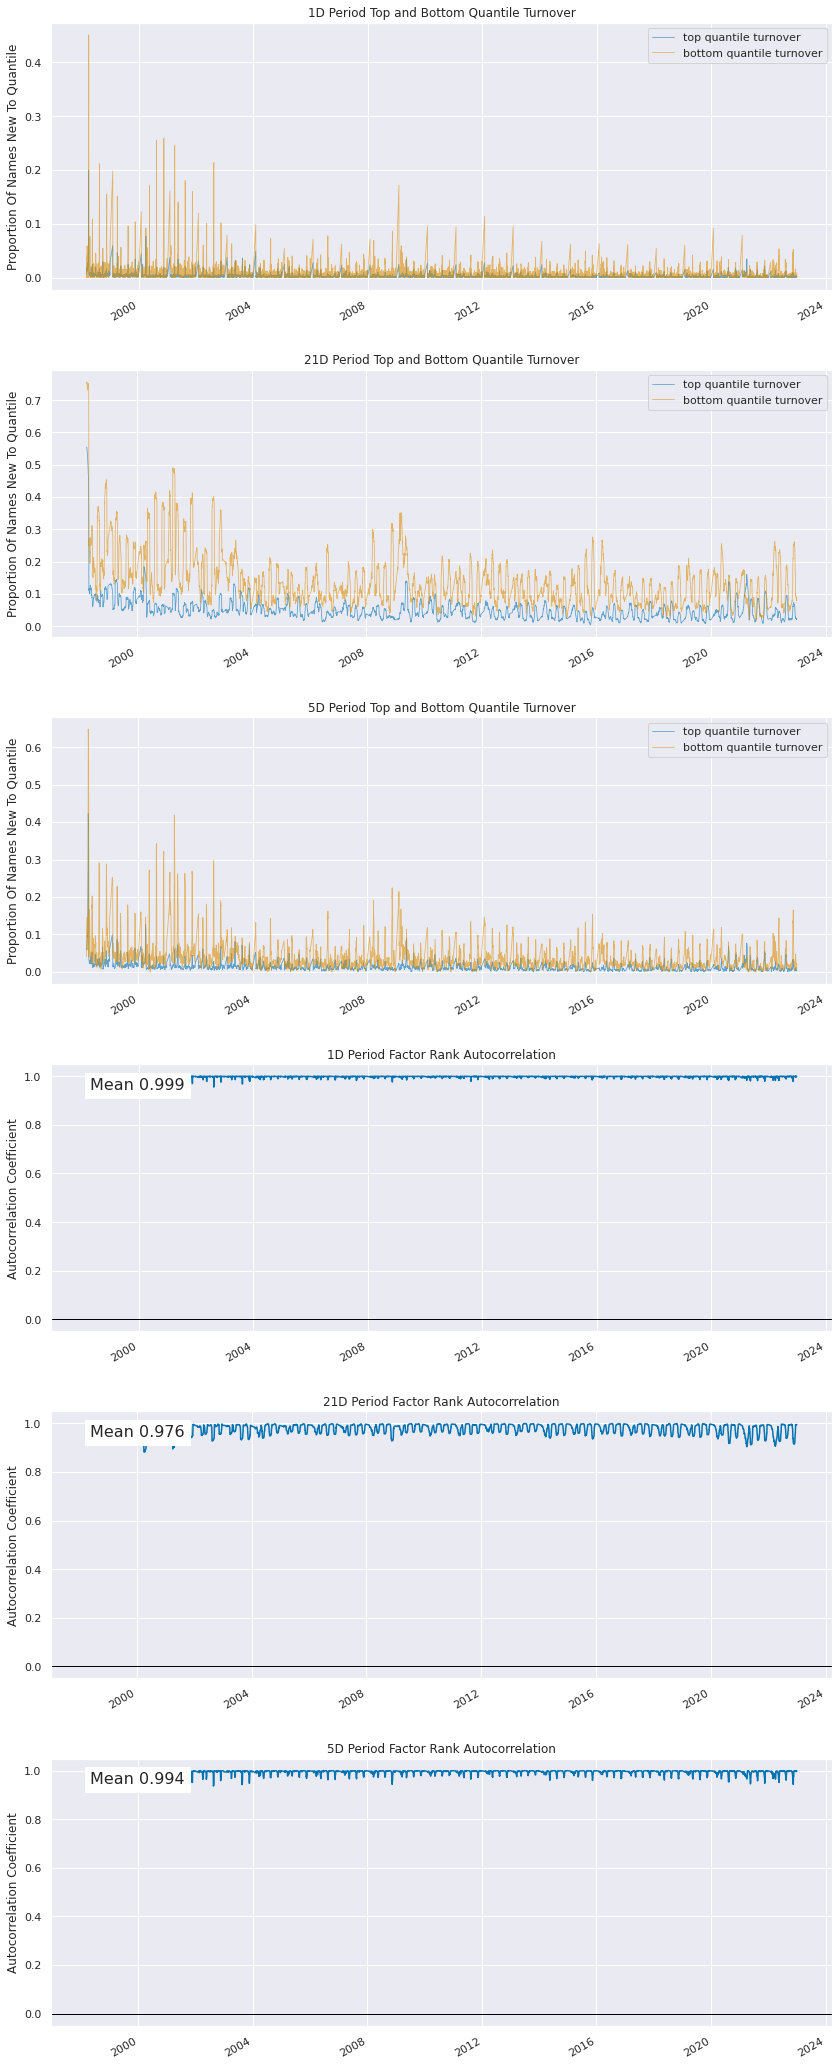

In [9]:
import alphalens as al

al.from_pipeline(
    pipeline,
    start_date="1998-02-01",
    end_date="2022-12-30",
    periods=[1, 5, 21],
    factor="altman",
    bins=[-float("inf"), 0, 3, float("inf")],
    segment="Y"
)

## Tear sheet commentary

### Factor Distribution table

* `min`/`max`: For each factor quantile, we can check the minimum and maximum values to make sure they are as we expected. Here, everything in quantile 1 is below 0, everything in quantile 2 is between 0 and 3, and everything in quantile 3 is above 3.
* `count %`: Because we defined the bin edges instead of using equal-sized quantiles, the quantiles are different sizes. Less than 10% of stocks are in the distress zone, 40% are in the grey zone, and 50% are in the safe zone.

### Returns Analysis

* `Mean Relative Return By Factor Quantile`: companies in distress perform worse than companies not in distress. There is little difference between the safe zone and the grey zone.

## Defining bin edges in Pipeline

Suppose you want to define the bin edges in Pipeline instead of in Alphalens, perhaps because you're not feeding the Pipeline output to Alphalens. A good way to do this is using the `Constant` factor. Here, we define a factor for the 3 Altman Z-Score zones, with 1 being the distress zone, 2 being the grey zone, and 3 being the safe zone:

In [10]:
from zipline.pipeline import Constant

altman = sharadar.AltmanZScore('ART')

altman_zone = Constant(1).where(altman<=0, Constant(2).where(altman<=3, Constant(3).where(altman > 3)))

***

## *Next Up*

Lesson 12: [Multi-Factor Scores](Lesson12-Multi-Factor-Scores.ipynb)